In [1]:
%run training_functions.ipynb

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-14 18:27:32.660863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744655252.675274 2018105 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744655252.679616 2018105 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744655252.692524 2018105 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
['train', 'validation', 'test']
['train', 'validation', 'test']
In, Out, get_ipython, exit, quit, open, accelerate, datasets, evaluate, math, np, os, peft, pickle, pytest, ipytest, pd, transformers, torch, time, threading, load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names, LoftQConfig, LoraConfig, get_peft_model, AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, Trainer, SFTTrainer, SFTConfig, @py_builtins, @pytest_ar, model_from_pkl, ds_builder1, ds_builder2, ds_builder3, ds_gs, ds_gst1_train, ds_gst1_test, ds_gst2_train, ds_gst2_test, search_with_strings, map_data, print_trainable_parameters, metric, initialize_heartbeat, heartbeat, end_heartbeat, comp_metrics_output, compute_metrics, make_trainer, get_dataframe, get_training_output, 

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [2]:
print(ds_gst1_train[0]['record'])

NZ_LIXJ01000001.1


In [3]:
print(ds_gst1_train[0]['text'][:1000])

CGACTCCGCACAGGCCCTAGGCGTGGTCCACGCATCGAGCGCGTGCGCCGTGGCATACACCCGGGCCACCCGTACGACCCTTCCGGCCGCCCCGTGTGCGCCCTCGTCGCCGAGTCCGCTCCGGCGCGCGCGGGCGCACTGCTGTTCCGCGCGGTGTCATGCGCTCCTCCCGTCCCGACATGCGCCTTTTTGCAGGGGAGAGGGAGGGGTAGGGTCGCGCGTACGCCTAGCACGGGGGAACGGTCTTGGGGGACGCAGTGGACGTACGGGTGGCGGCGATCGCCAGTCTCACACCGCTCGAAGAACTCGACAGCGATCCGTTCCTCGTGGACACCCGCAGCCAGCACGACATGTGCGCACGCTGGGCCGCGGACAAGGGGTACGTCGTCACCCGCCAGCTCCGCTTCTACGGGCTGCGCCCCGATCACCACGCCCTGTGGAGCGATGTCGAGAGCGGCGACGTCGAGGTGTTCGTCGCCGCCAACGACCGGGTGCTGGAACGGGCCCTCACGTCGGTCGCGGAGTTCGCCGCGGAGTGCGCGCGGCGCGGCGTGCGTCTGGAGATCGCCGGGCTGGACGAGCCGCCGTACAACGCCGGCACGAAGGCGAGCGTGCATCGCAGGCTCTCCATGCCCACCGCCGGTTACGACGGCCGCTGACGCACTCCGCCTCCACTGCCGGCTCGCGGCCCCTGCCCTCGTCCCGGCCCCGTCCCTTCCGCGGCTTGCCGTCGGGCTGTGACAGGCTGGGGGACAGGGTCCGCAGCGGCGGGGCCCGGACGTGAGGTGGTTGAGGCGTGGGTGACGGGCGATGGCGAACGGTCGGCAACGCCCTGATGCGAGTGGCCGTGGTGTGGGCGGTCTCCACGCTCACGATGCTGGTGCTCGCCGGGGTGCTGCCGGAGTTCCGGCTCCAGTCGGACGACGGCGACAGCATCACCAAGACCGCGTTCACCGCGGCCTGGGGCGCCGGAGCGTTCGGCCTGCTCTCCGCACTCGTC

In [4]:
mistral, mistral_tokenizer=model_from_pkl("Mistral-7B-Instruct-v0.1")

In [5]:
m_tokenized_genome_samples=map_data(ds_gs, mistral, mistral_tokenizer)

In [6]:
m_tokenized_stage1_train=map_data(ds_gst1_train, mistral, mistral_tokenizer)
m_tokenized_stage1_test=map_data(ds_gst1_test, mistral, mistral_tokenizer)

In [7]:
m_tokenized_stage2_train=map_data(ds_gst2_train, mistral, mistral_tokenizer)
m_tokenized_stage2_test=map_data(ds_gst2_test, mistral, mistral_tokenizer)

In [8]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [9]:
mis_lora_model=get_peft_model(mistral, config)
print_trainable_parameters(mis_lora_model)

trainable params: 3407872 || all params: 7245139968 || trainable%: 0.05


In [10]:
m_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps", 
                                    logging_steps=50, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                    fp16=True))

# Using the SFTConfig default values provides us with...
# num_train_epochs = 3.0
# eval_strategy: typing.Union[transformers.trainer_utils.IntervalStrategy, str] = 'no'
# per_device_train_batch_size = 8
# learning_rate = 2e-5
# gradient_checkpointing=False

In [11]:
state=initialize_heartbeat()
m_trainer.train()
end_heartbeat(state)

The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.627400,2.466227
100,0.609800,2.441739
150,0.606000,2.433480
200,0.603100,2.428656
250,0.602200,2.425179
300,0.602600,2.423435
350,0.601400,2.422754
400,0.601400,2.422242
450,0.600200,2.421378
500,0.600900,2.420958


The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running


In [12]:
m_trainer.args.eval_strategy.value

'steps'

,loss,eval_loss
steps,,
50,0.6274,2.466227
100,0.6098,2.441739
150,0.6060,2.433480
200,0.6031,2.428656
250,0.6022,2.425179
300,0.6026,2.423435
350,0.6014,2.422754
400,0.6014,2.422242
450,0.6002,2.421378


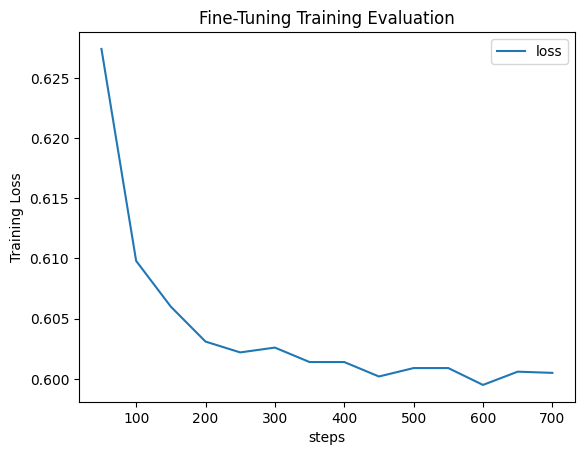

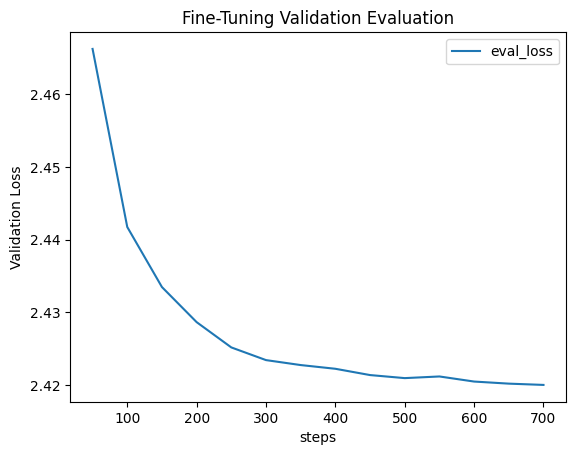

In [13]:
output=get_training_output(m_trainer, ['loss', 'eval_loss'])
#output=get_training_output(m_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [21]:
m2_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps", 
                                    logging_steps=5, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

In [22]:
state=initialize_heartbeat()
m2_trainer.train()
end_heartbeat(state)

The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.597000,2.412825
2,0.595300,2.411485
3,0.594400,2.410717


The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


,loss,eval_loss
epoch,,
1.0,0.5970,2.412825
2.0,0.5953,2.411485
3.0,0.5944,2.410717


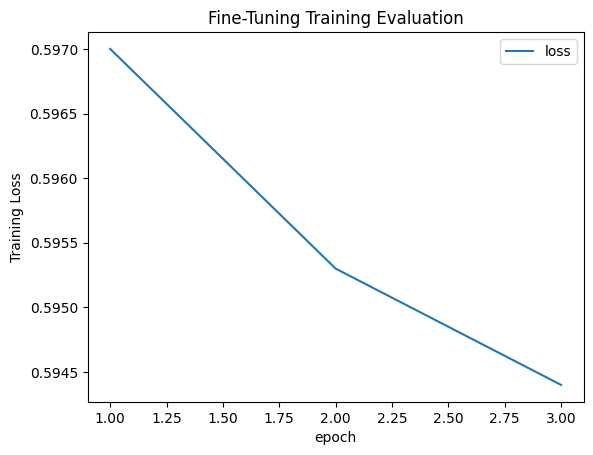

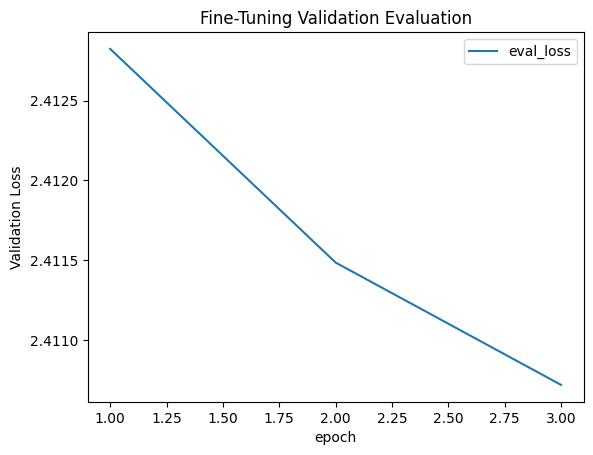

In [23]:
output=get_training_output(m2_trainer, ['loss', 'eval_loss'])
#output=get_training_output(m2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [17]:
m_trainer.model.save_pretrained('./fine_tuned/mis/')
m2_trainer.model.save_pretrained('./fine_tuned/mis2/')

In [18]:
m_trainer.processing_class.save_pretrained('./fine_tuned/mis_token/')

('./fine_tuned/mis_token/tokenizer_config.json',
 './fine_tuned/mis_token/special_tokens_map.json',
 './fine_tuned/mis_token/tokenizer.model',
 './fine_tuned/mis_token/added_tokens.json',
 './fine_tuned/mis_token/tokenizer.json')

In [19]:
m2_trainer.processing_class.save_pretrained('./fine_tuned/mis2_token/')

('./fine_tuned/mis2_token/tokenizer_config.json',
 './fine_tuned/mis2_token/special_tokens_map.json',
 './fine_tuned/mis2_token/tokenizer.model',
 './fine_tuned/mis2_token/added_tokens.json',
 './fine_tuned/mis2_token/tokenizer.json')